In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import os
from utils.experiment_logging import get_results, get_config


import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
font = {'family' : 'normal',
        'size'   : 14}
matplotlib.rc('font', **font)

all_experiment_names = ['mixing-random', 'rewiring-edges', 'mode-collapse', 'mode-dropping']
all_data_names = ['lobster', 'grid', 'community', 'ego', 'proteins', 'zinc']
all_model_names = ['graphcl', 'gin-random', 'infograph']

writing_saving_name = {'no_struct_feats': 'no structural features',
                      'deg_feats': 'with degree features',
                      'clustering_feats': 'with clustering structural features'}

In [3]:
def get_data(testing_path, model_name, perturbation, data_name=None):
    exp_results = []
    path = testing_path + f'/{model_name}/{perturbation}'
    if data_name is not None:
        path += f'/{data_name}'
    for root, subdir, files in os.walk(path):
        if 'results.h5' not in files:
            continue

        with open(root+'/results.h5','rb') as file:
            data = pickle.load(file)
            try:
                if data[-1]['ratio'] < 1:
                    print('incomplete experiment found: ', root)
                    
                else:
                    exp_results.append(data)
            except:
                print('can not read file: ', root)
            
    final_results = [exp[0] for exp in exp_results]
    
    rank_corr_fid = np.array([exp['rank_corr_fid'] for exp in final_results]).reshape(1,-1)
    rank_corr_precision = np.array([exp['rank_corr_precision'] for exp in final_results]).reshape(1,-1)
    rank_corr_recall = np.array([exp['rank_corr_recall'] for exp in final_results]).reshape(1,-1)
    rank_corr_f1_pr = np.array([exp['rank_corr_f1_pr'] for exp in final_results]).reshape(1,-1)
    rank_corr_density = np.array([exp['rank_corr_density'] for exp in final_results]).reshape(1,-1)
    rank_corr_coverage = np.array([exp['rank_corr_coverage'] for exp in final_results]).reshape(1,-1)
    rank_corr_f1_dc = np.array([exp['rank_corr_f1_dc'] for exp in final_results]).reshape(1,-1)
    rank_corr_mmd_rbf = np.array([exp['rank_corr_mmd_rbf'] for exp in final_results]).reshape(1,-1)
    rank_corr_mmd_linear = np.array([exp['rank_corr_mmd_linear'] for exp in final_results]).reshape(1,-1)
    
    values = np.concatenate([rank_corr_precision, rank_corr_density, rank_corr_recall, rank_corr_coverage,
                         rank_corr_f1_pr, rank_corr_f1_dc, rank_corr_fid, rank_corr_mmd_linear, rank_corr_mmd_rbf],
                         axis=1).reshape(-1,1)
    names = np.array(['Precision', 'Density', 'Recall', 'Coverage', 'F1 PR', 
                                         'F1 DC', 'FD', 'MMD Linear', 'MMD RBF']).reshape(-1,1)
    x = np.repeat(names, rank_corr_fid.shape[1]).reshape(-1,1)
    df = pd.DataFrame(values, columns=['values'])
    df['names'] = x
    
    return df
    

In [4]:
def plot_violin_results_compare(path, model_names, perturbation, saving_name, data_name=None):
    
    writing_names = {'gin': 'GraphCL', 'graphcl': 'GraphCL', 'gin-random': 'GIN-Random', 'infograph':'InfoGraph',
                    'graphcl-no-lipchitz':'GraphCL2', 'graphcl-no-subgraph':'GraphCL3'}
    
    dfs = []
    names = []
    for model_name in model_names:
        df = get_data(path, model_name, perturbation, data_name)
        names = [writing_names[model_name]] * df.shape[0]
        df['model name'] = names
        dfs.append(df)
    
    df = pd.concat(dfs)

    
    ax = sns.violinplot(x='names', y='values', hue="model name",
                    data=df, palette="muted")
    ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
    plt.ylim(-0.5, 1.0)
    title = perturbation
    if data_name is not None:
        title += f'/{data_name}'
    plt.title(title)
    plt.ylabel('Rank Correlation')
    plt.xlabel('')
    plt.legend(loc='lower center')
    if data_name is not None:
        saving_name += f'_{data_name}'
    plt.savefig(f'figs/{perturbation}_{saving_name}.pdf', bbox_inches='tight')
    plt.show()
    
    

In [18]:
def create_latex_for_plots(data_name, saving_name):
    fig_latex = '''\\begin{figure*}[h!]
    \captionsetup[subfloat]{farskip=-2pt,captionskip=-8pt}
    \centering''' + '\n'
    
    fig_latex += '    \subfloat[][]{\includegraphics[width = 2.55in]{figures/mixing-random_'+saving_name+f'_{data_name}'+'.pdf}}' + '\n'
    fig_latex += '    \subfloat[][]{\includegraphics[width = 2.55in]{figures/rewiring-edges_'+saving_name+f'_{data_name}'+'.pdf}}' + '\n'
    fig_latex += '    \\\\' + '\n'
    fig_latex += '    \subfloat[][]{\includegraphics[width = 2.55in]{figures/mode-collapse_'+saving_name+f'_{data_name}'+'.pdf}}' + '\n'
    fig_latex += '    \subfloat[][]{\includegraphics[width = 2.55in]{figures/mode-dropping_'+saving_name+f'_{data_name}'+'.pdf}}' + '\n'

    fig_latex += '    \caption{Violing comparative results among the methods, with '+ writing_saving_name[saving_name] + f' for {data_name} dataset' +'.}' + '\n'
    fig_latex += '    \label{fig:'+saving_name+'_'+data_name+'}' + '\n'
    fig_latex += '\end{figure*}'
    
    
    return fig_latex

In [19]:
saving_name = 'no_struct_feats'
data_name = 'grid'
print(create_latex_for_plots(data_name, saving_name))

\begin{figure*}[h!]
    \captionsetup[subfloat]{farskip=-2pt,captionskip=-8pt}
    \centering
    \subfloat[][]{\includegraphics[width = 2.55in]{figures/mixing-random_no_struct_feats_grid.pdf}}
    \subfloat[][]{\includegraphics[width = 2.55in]{figures/rewiring-edges_no_struct_feats_grid.pdf}}
    \\
    \subfloat[][]{\includegraphics[width = 2.55in]{figures/mode-collapse_no_struct_feats_grid.pdf}}
    \subfloat[][]{\includegraphics[width = 2.55in]{figures/mode-dropping_no_struct_feats_grid.pdf}}
    \caption{Violing comparative results among the methods, with no structural features for grid dataset.}
    \label{fig:no_struct_feats_grid}
\end{figure*}


In [20]:
def get_latex_table_row(testing_path, model_name, perturbation, data_name=None):
    exp_results = []
    path = testing_path + f'/{model_name}/{perturbation}'
    if data_name is not None:
        path += f'/{data_name}'
    for root, subdir, files in os.walk(path):
        if 'results.h5' not in files:
            continue

        with open(root+'/results.h5','rb') as file:
            data = pickle.load(file)
            try:
                if data[-1]['ratio'] < 1:
                    print('incomplete experiment found: ', root)
                    
                else:
                    exp_results.append(data)
            except:
                print('can not read file: ', root)
            
    final_results = [exp[0] for exp in exp_results]
    
    rank_corr_precision = np.array([exp['rank_corr_precision'] for exp in final_results]).reshape(-1)
    rank_corr_density = np.array([exp['rank_corr_density'] for exp in final_results]).reshape(-1)
    rank_corr_recall = np.array([exp['rank_corr_recall'] for exp in final_results]).reshape(-1)
    rank_corr_coverage = np.array([exp['rank_corr_coverage'] for exp in final_results]).reshape(-1)
    rank_corr_f1_pr = np.array([exp['rank_corr_f1_pr'] for exp in final_results]).reshape(-1)
    rank_corr_f1_dc = np.array([exp['rank_corr_f1_dc'] for exp in final_results]).reshape(-1)
    rank_corr_fid = np.array([exp['rank_corr_fid'] for exp in final_results]).reshape(-1)
    rank_corr_mmd_linear = np.array([exp['rank_corr_mmd_linear'] for exp in final_results]).reshape(-1)
    rank_corr_mmd_rbf = np.array([exp['rank_corr_mmd_rbf'] for exp in final_results]).reshape(-1)
    
    
    arrays = [rank_corr_precision, rank_corr_density, rank_corr_recall, rank_corr_coverage,
                         rank_corr_f1_pr, rank_corr_f1_dc, rank_corr_fid, rank_corr_mmd_linear, rank_corr_mmd_rbf]
    means = ['Mean'] + [str(np.round(np.mean(x), 2)) for x in arrays]
    medians = ['Median'] + [str(np.round(np.median(x), 2)) for x in arrays]
    
    s_mean = ' & '.join(means)
    s_median = ' & '.join(medians)
    
    return s_mean, s_median
    

In [24]:
def get_latex_table(path, model_names, perturbations, saving_name, data_name=None):
    writing_names_model_names = {'gin': 'GraphCL', 'graphcl': 'GraphCL', 'gin-random': 'GIN-Random', 'infograph':'InfoGraph',
                    'graphcl-no-lipchitz':'GraphCL2', 'graphcl-no-subgraph':'GraphCL3'}
    writing_names_perturbs = {'mixing-random': 'Mixing Random', 'rewiring-edges': 'Rewiring Edges', 
                              'mode-collapse': 'Mode Collapse', 'mode-dropping': 'Mode Dropping'}
    
    caption = '\caption{' + f'Mean and median values for measurements in experiments with {writing_saving_name[saving_name]} by models, for dataset {data_name}' + '} ' + '\n'
    label = '\label{table:' + saving_name + '_' + data_name + '}' + '\n'
    table_str = '''\\begin{table}[h!]
\centering
\\begin{small}
\scalebox{0.7}{
\\begin{tabular}{l|l|l|l|l|l|l|l|l|l|l|l} 
\\toprule
Model Name               & Experiment                      &        & Precision & Density & Recall & Coverage & F1PR & F1DC & FD & MMD Lin & MMD RBF  \\\\ 
\hline''' + '\n'
    
    for i, model_name in enumerate(model_names):
        model_str = '\multirow{' + str(2*len(perturbations)) + '}{*}{' + writing_names_model_names[model_name] + '} '
        for j, perturb in enumerate(perturbations):
            pert_str = ' &    \multirow{2}{*}{' + writing_names_perturbs[perturb] + '} & '
            s_mean, s_median = get_latex_table_row(path, model_name, perturb, data_name)
            pert_str += s_mean + ''' \\\\
\cline{3-12}
                   &     & ''' + s_median + ' \\\\ '
            
            if j != len(perturbations)-1:
                pert_str += '\n' + '\cline{2-12}' + '\n'
                
            model_str += pert_str
        
        if i != len(model_names)-1:
            model_str += '\n' + '\cline{1-12}' + '\n'
            
        table_str += model_str
        
    table_str += '\\bottomrule' + '\n'
    table_str +='''\end{tabular}
}
\end{small}'''
    table_str += '\n' + caption + label + '\end{table}'
    
                
        
            
    return table_str
    

In [22]:
path = 'experiment_results/testing_no_feats'
saving_name = 'no_struct_feats'
model_names = ['graphcl','infograph','gin-random']
perturbations = all_experiment_names

latex_str = ""
for data_name in all_data_names:
    latex_str += create_latex_for_plots(data_name, saving_name) + '\n \n'
    latex_str += get_latex_table(path, model_names, perturbations, saving_name, data_name=data_name) + '\n \n'
    
print(latex_str)
with open('experiment_results/latex texts/' + saving_name + 'figs_tables', 'ab+') as f:
    pickle.dump(latex_str, f)

\begin{figure*}[h!]
    \captionsetup[subfloat]{farskip=-2pt,captionskip=-8pt}
    \centering
    \subfloat[][]{\includegraphics[width = 2.55in]{figures/mixing-random_no_struct_feats_lobster.pdf}}
    \subfloat[][]{\includegraphics[width = 2.55in]{figures/rewiring-edges_no_struct_feats_lobster.pdf}}
    \\
    \subfloat[][]{\includegraphics[width = 2.55in]{figures/mode-collapse_no_struct_feats_lobster.pdf}}
    \subfloat[][]{\includegraphics[width = 2.55in]{figures/mode-dropping_no_struct_feats_lobster.pdf}}
    \caption{Violing comparative results among the methods, with no structural features for lobster dataset.}
    \label{fig:no_struct_feats_lobster}
\end{figure*}
 
\begin{table}[h!]
\centering
\begin{small}
\scalebox{0.7}{
\begin{tabular}{l|l|l|l|l|l|l|l|l|l|l|l} 
\toprule
Model Name               & Experiment                      &        & Precision & Density & Recall & Coverage & F1PR & F1DC & FD & MMD Lin & MMD RBF  \\ 
\hline
\multirow{8}{*}{GraphCL}  &    \multirow{2}{*}{Mi

In [26]:
path = 'experiment_results/testing_deg_feats'
saving_name = 'deg_feats'
model_names = ['graphcl','gin-random']
perturbations = all_experiment_names

latex_str = ""
for data_name in all_data_names:
    latex_str += create_latex_for_plots(data_name, saving_name) + '\n \n'
    latex_str += get_latex_table(path, model_names, perturbations, saving_name, data_name=data_name) + '\n \n'
    
print(latex_str)
with open('experiment_results/latex texts/' + saving_name + 'figs_tables', 'ab+') as f:
    pickle.dump(latex_str, f)

\begin{figure*}[h!]
    \captionsetup[subfloat]{farskip=-2pt,captionskip=-8pt}
    \centering
    \subfloat[][]{\includegraphics[width = 2.55in]{figures/mixing-random_deg_feats_lobster.pdf}}
    \subfloat[][]{\includegraphics[width = 2.55in]{figures/rewiring-edges_deg_feats_lobster.pdf}}
    \\
    \subfloat[][]{\includegraphics[width = 2.55in]{figures/mode-collapse_deg_feats_lobster.pdf}}
    \subfloat[][]{\includegraphics[width = 2.55in]{figures/mode-dropping_deg_feats_lobster.pdf}}
    \caption{Violing comparative results among the methods, with with degree features for lobster dataset.}
    \label{fig:deg_feats_lobster}
\end{figure*}
 
\begin{table}[h!]
\centering
\begin{small}
\scalebox{0.7}{
\begin{tabular}{l|l|l|l|l|l|l|l|l|l|l|l} 
\toprule
Model Name               & Experiment                      &        & Precision & Density & Recall & Coverage & F1PR & F1DC & FD & MMD Lin & MMD RBF  \\ 
\hline
\multirow{8}{*}{GraphCL}  &    \multirow{2}{*}{Mixing Random} & Mean & 1.0 & 1.0 

In [27]:
path = 'experiment_results/testing_clustering_feats'
saving_name = 'clustering_feats'
model_names = ['graphcl','infograph']
perturbations = all_experiment_names

latex_str = ""
for data_name in all_data_names:
    latex_str += create_latex_for_plots(data_name, saving_name) + '\n \n'
    latex_str += get_latex_table(path, model_names, perturbations, saving_name, data_name=data_name) + '\n \n'
    
print(latex_str)
with open('experiment_results/latex texts/' + saving_name + 'figs_tables', 'ab+') as f:
    pickle.dump(latex_str, f)

incomplete experiment found:  experiment_results/testing_clustering_feats/infograph/rewiring-edges/proteins/20220526-115524-iK2ZWeqhFW
can not read file:  experiment_results/testing_clustering_feats/infograph/rewiring-edges/proteins/20220526-122113-pLIix6MEOL
can not read file:  experiment_results/testing_clustering_feats/infograph/rewiring-edges/proteins/20220526-120213-iK2ZWeqhFW
\begin{figure*}[h!]
    \captionsetup[subfloat]{farskip=-2pt,captionskip=-8pt}
    \centering
    \subfloat[][]{\includegraphics[width = 2.55in]{figures/mixing-random_clustering_feats_lobster.pdf}}
    \subfloat[][]{\includegraphics[width = 2.55in]{figures/rewiring-edges_clustering_feats_lobster.pdf}}
    \\
    \subfloat[][]{\includegraphics[width = 2.55in]{figures/mode-collapse_clustering_feats_lobster.pdf}}
    \subfloat[][]{\includegraphics[width = 2.55in]{figures/mode-dropping_clustering_feats_lobster.pdf}}
    \caption{Violing comparative results among the methods, with with clustering structural featu

# Ablation Studies

experiment_results/testing_ablation/graphcl/mixing-random/zinc
experiment_results/testing_ablation/graphcl-no-lipchitz/mixing-random/zinc
experiment_results/testing_ablation/graphcl-no-subgraph/mixing-random/zinc


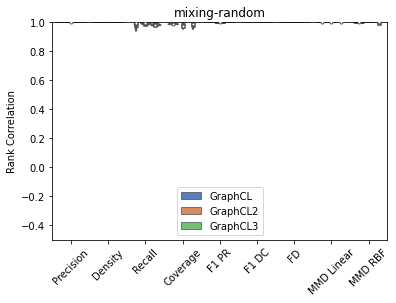

In [28]:
path = 'experiment_results/testing_ablation'
saving_name = 'ablation_studies'
plot_violin_results_compare(path, ['graphcl', 'graphcl-no-lipchitz', 'graphcl-no-subgraph'],
                            'mixing-random', saving_name, data_name='zinc')

# No Structural Features:

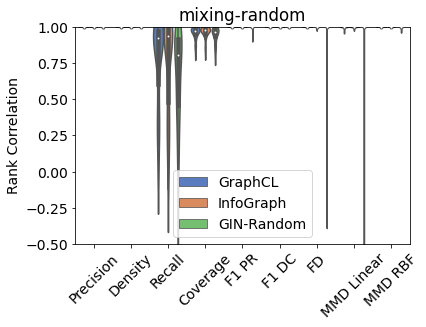

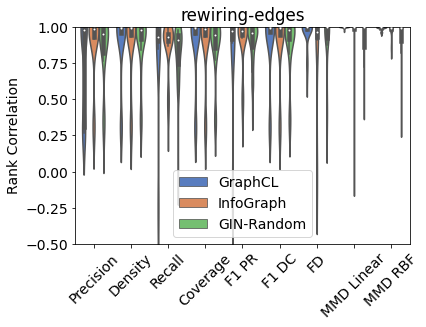

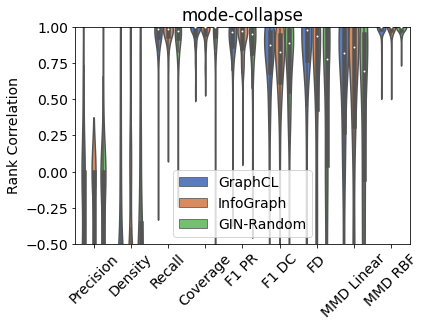

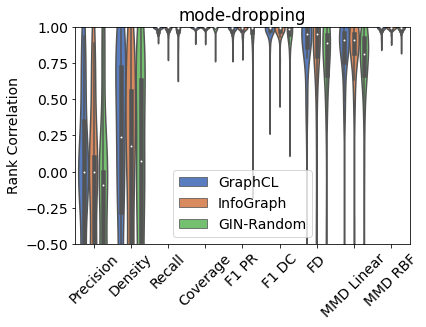

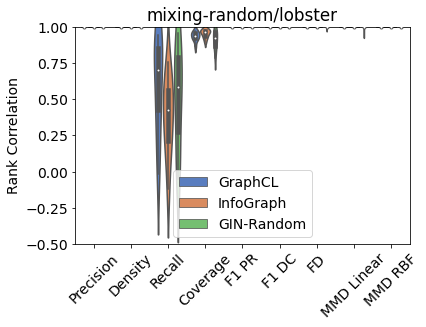

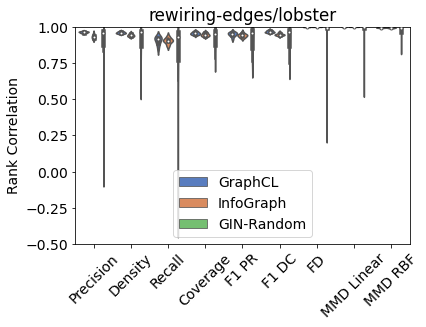

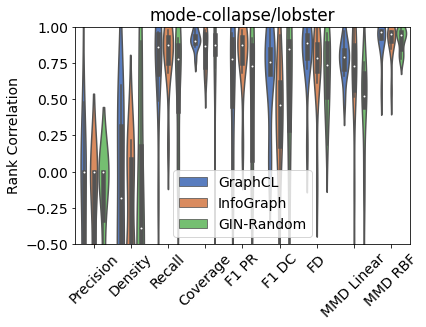

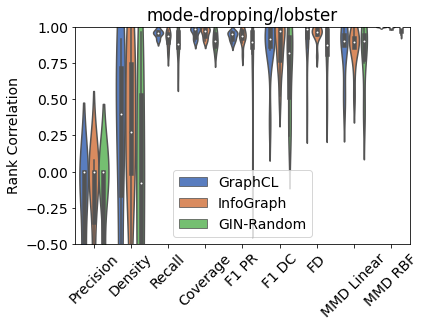

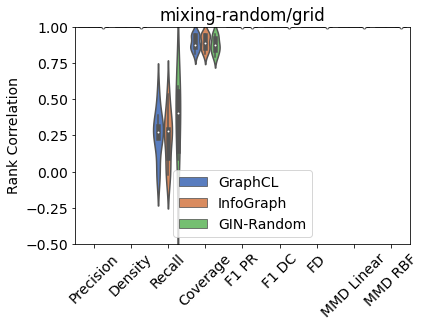

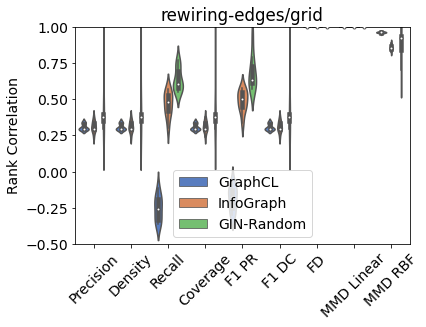

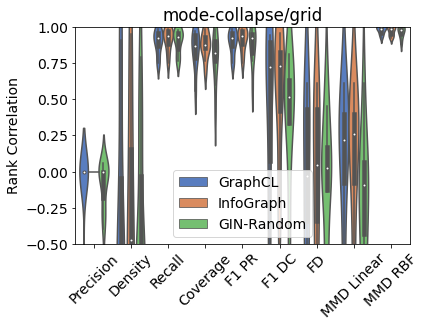

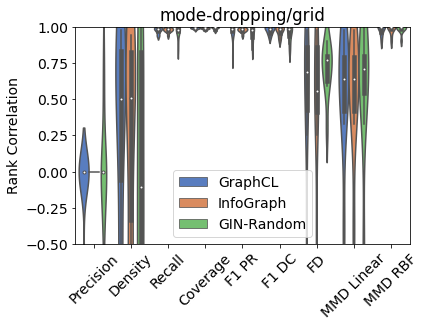

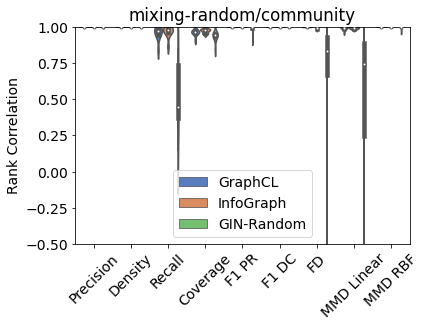

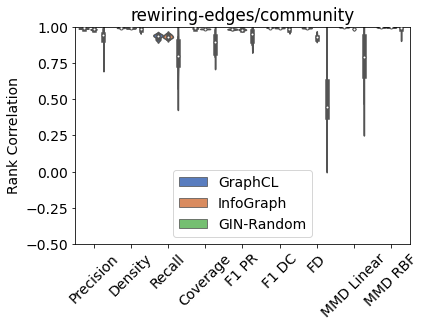

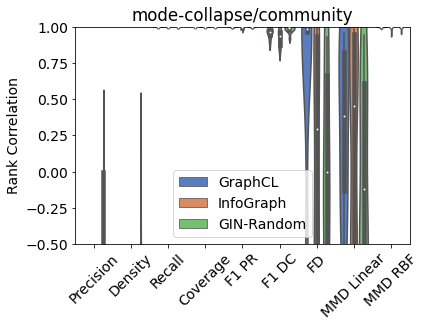

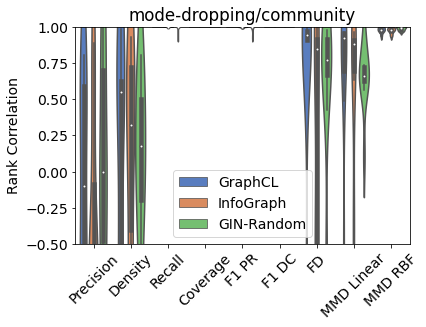

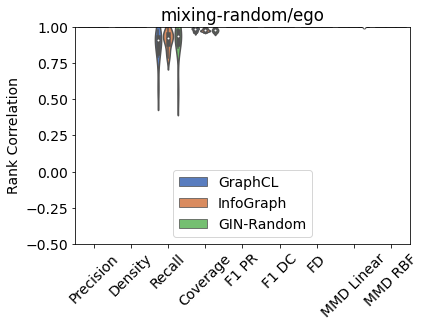

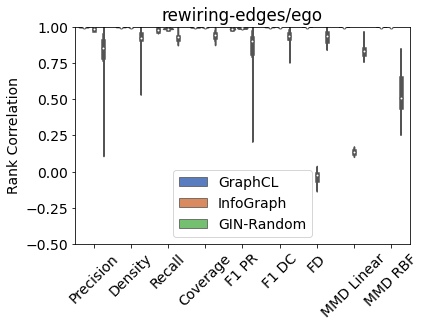

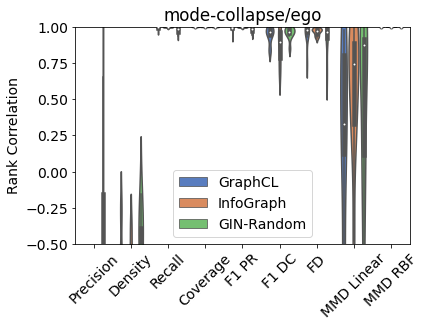

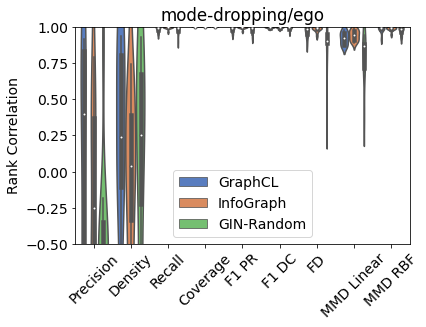

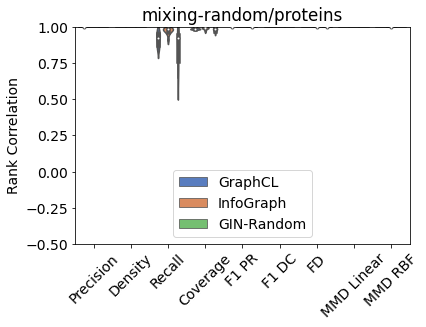

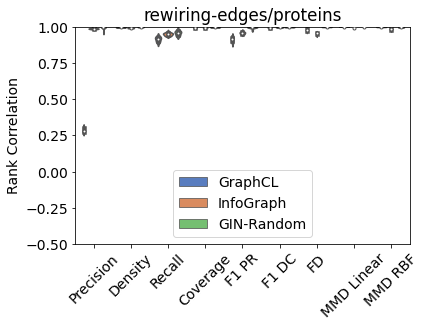

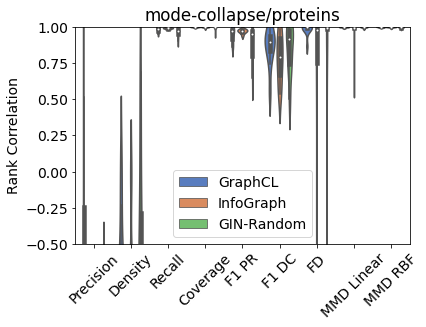

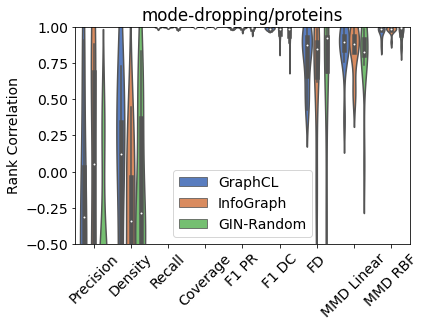

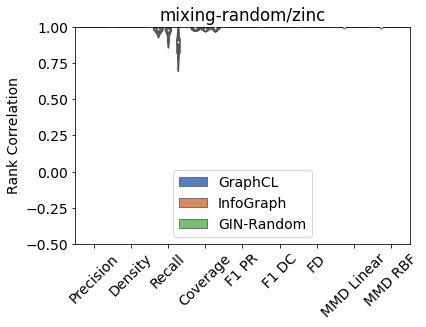

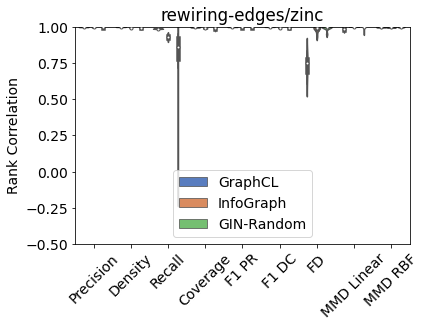

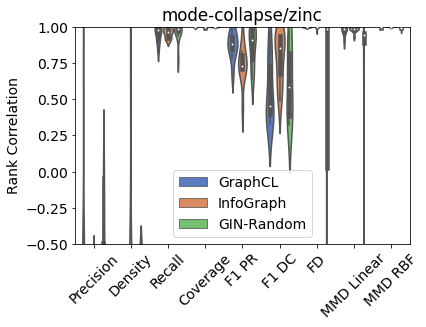

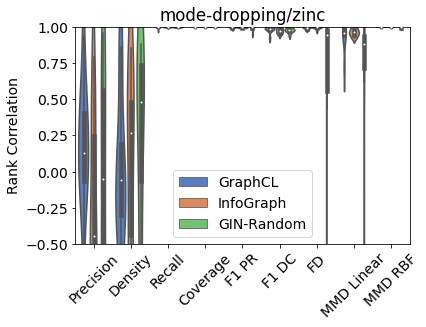

In [79]:
path = 'experiment_results/testing_no_feats'
saving_name = 'no_struct_feats'
model_names = ['graphcl', 'infograph', 'gin-random']
for experiment in all_experiment_names:
    plot_violin_results_compare(path, model_names, experiment, saving_name)
    
for data_name in all_data_names:
    for experiment in all_experiment_names:
        plot_violin_results_compare(path, model_names, experiment, saving_name, data_name)

# Degree Features:

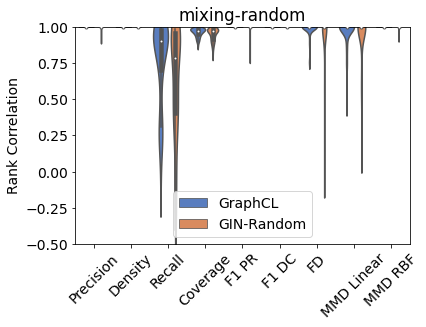

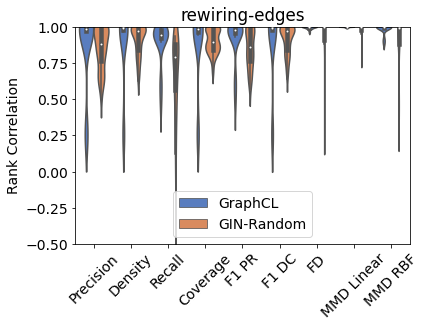

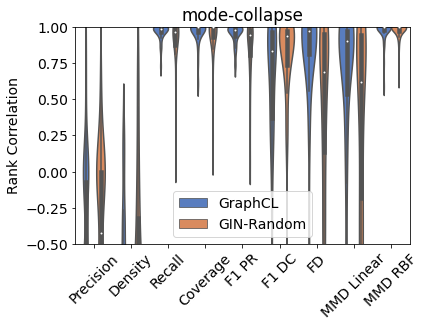

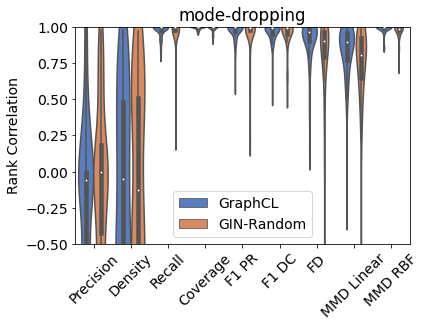

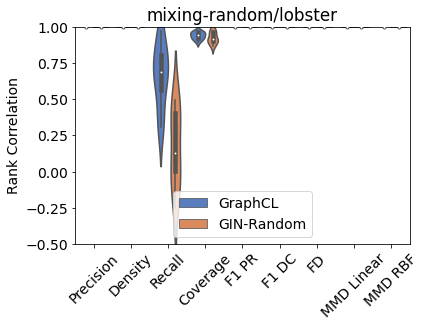

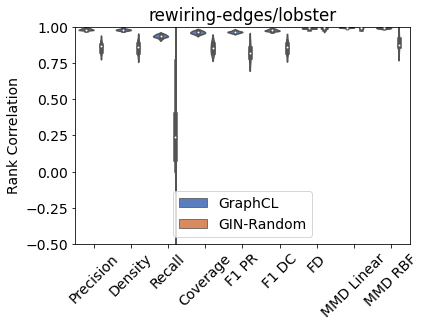

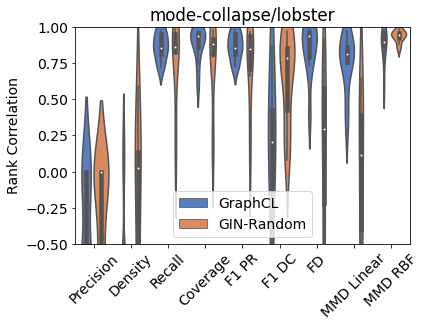

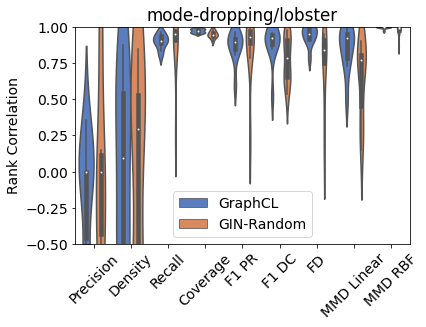

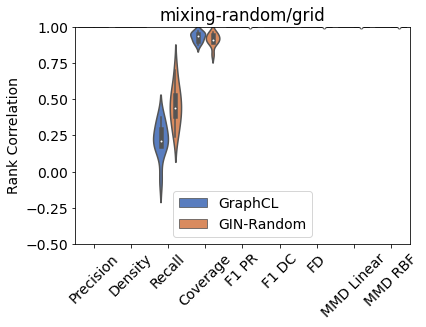

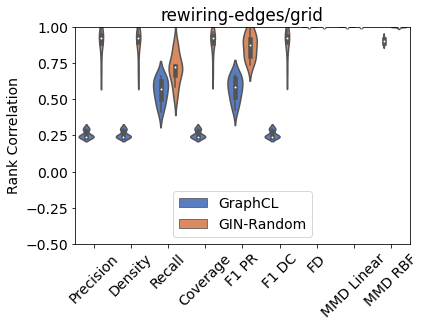

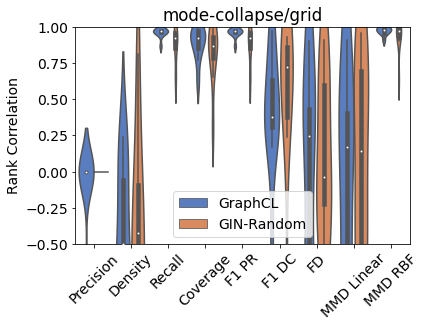

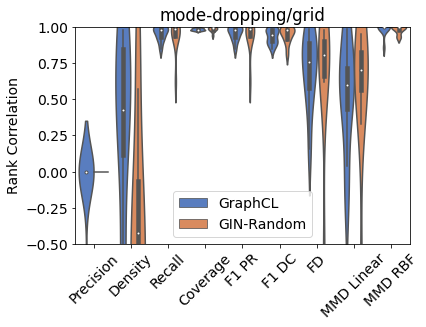

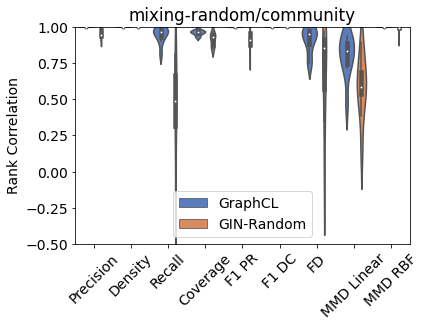

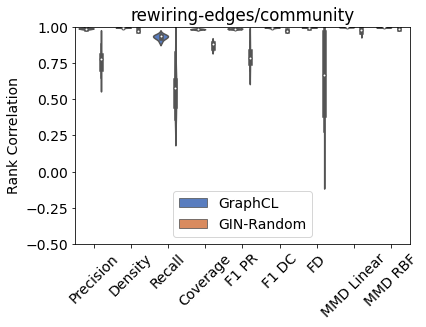

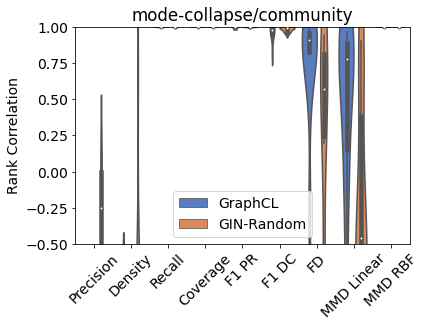

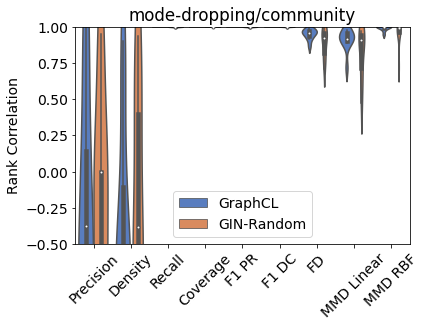

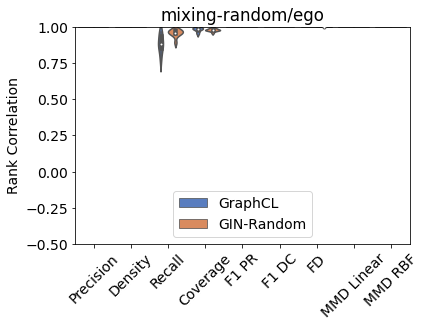

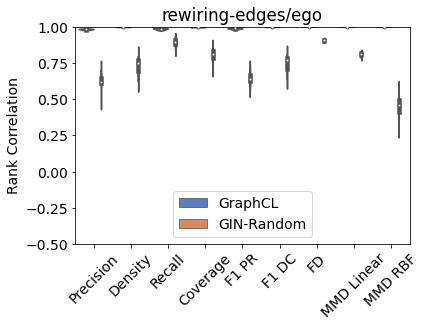

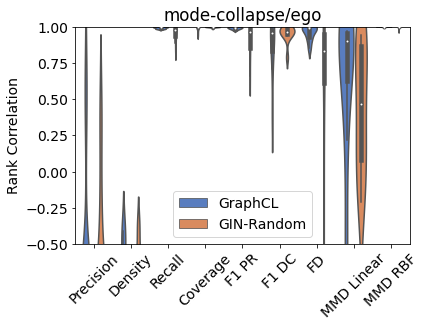

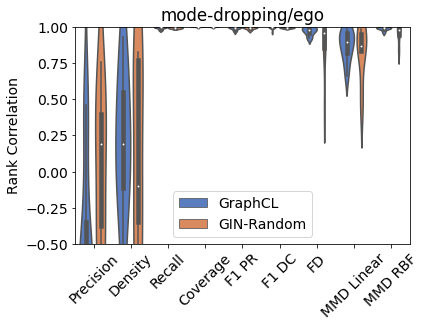

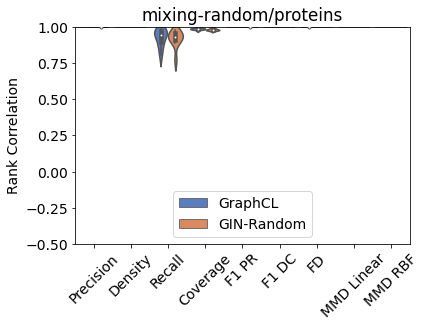

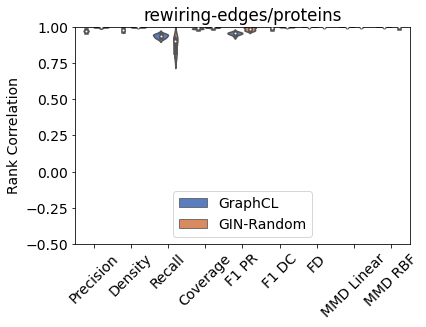

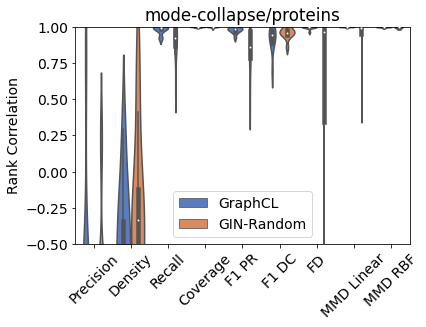

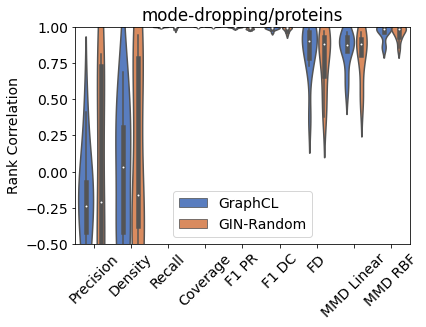

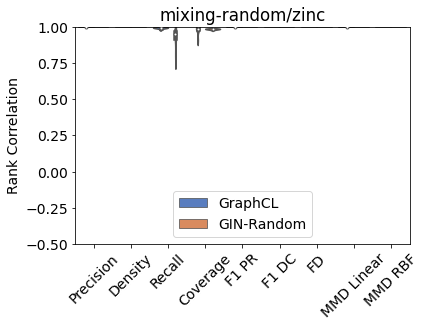

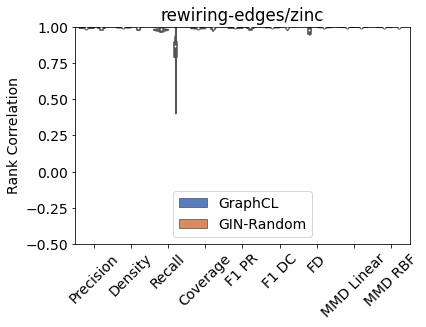

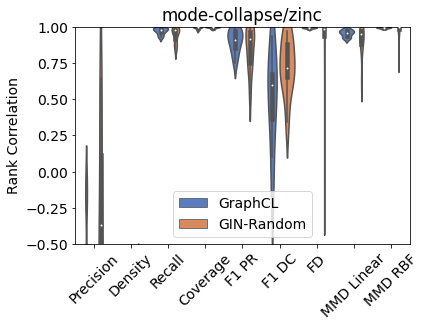

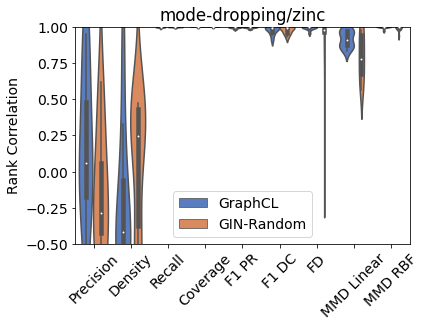

In [49]:
path = 'experiment_results/testing_deg_feats'
saving_name = 'deg_feats'
model_names = ['graphcl', 'gin-random']
for experiment in all_experiment_names:
    plot_violin_results_compare(path, model_names, experiment, saving_name)
    
for data_name in all_data_names:
    for experiment in all_experiment_names:
        plot_violin_results_compare(path, model_names, experiment, saving_name, data_name)

# Clustering Features:

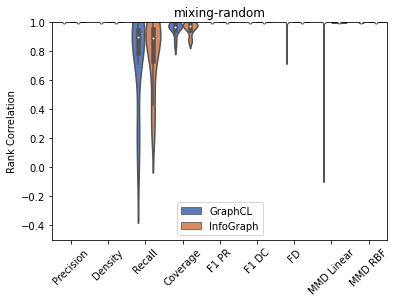

incomplete experiment found:  experiment_results/testing_clustering_feats/infograph/rewiring-edges/proteins/20220526-115524-iK2ZWeqhFW
can not read file:  experiment_results/testing_clustering_feats/infograph/rewiring-edges/proteins/20220526-122113-pLIix6MEOL
can not read file:  experiment_results/testing_clustering_feats/infograph/rewiring-edges/proteins/20220526-120213-iK2ZWeqhFW


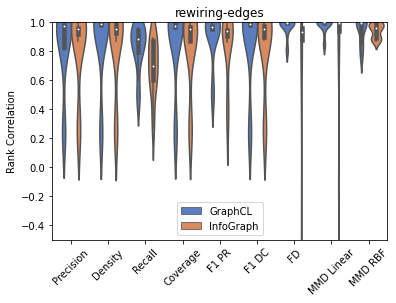

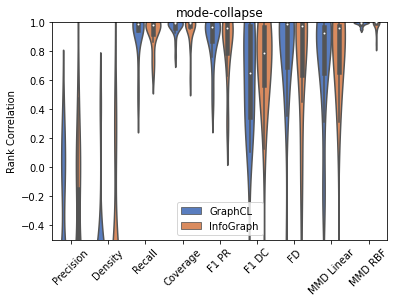

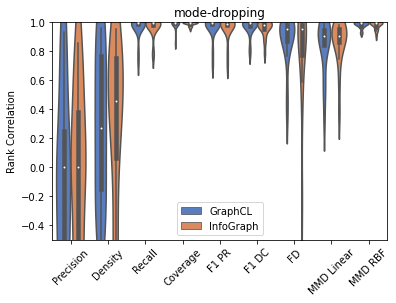

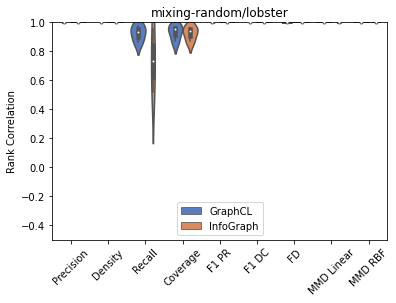

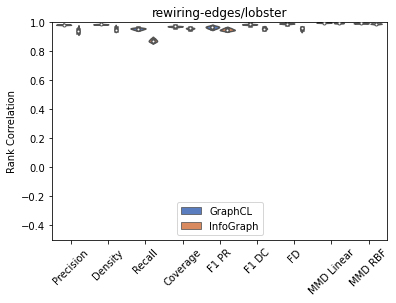

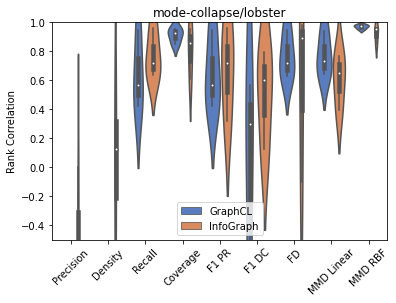

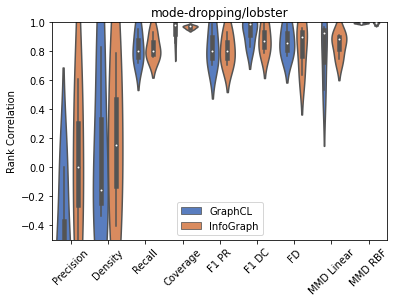

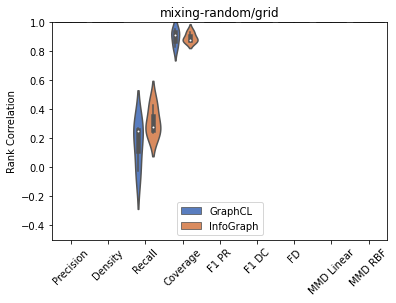

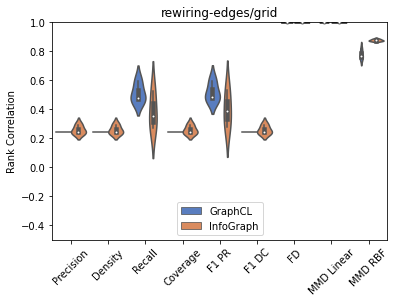

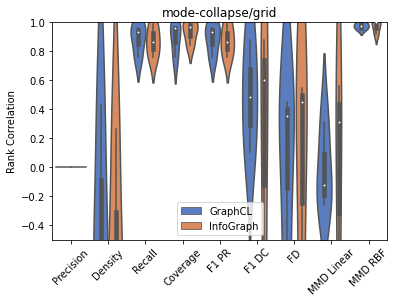

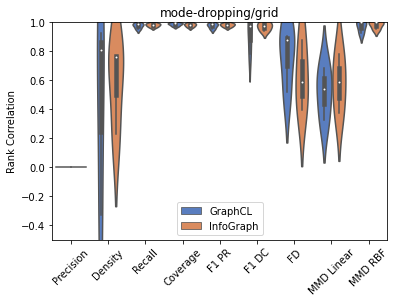

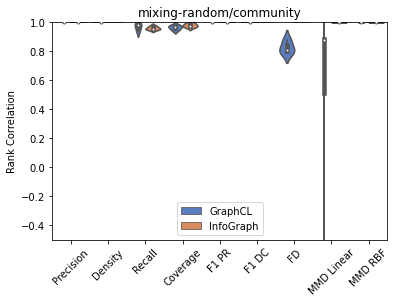

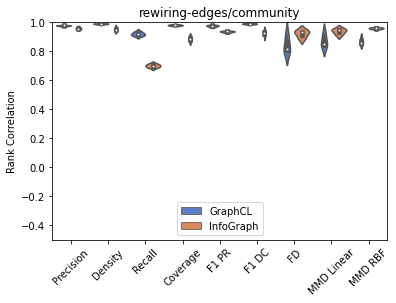

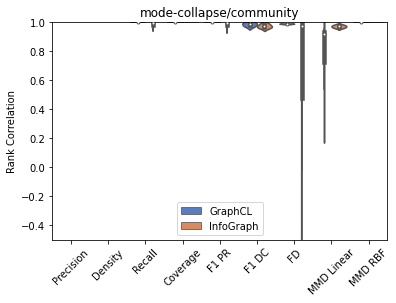

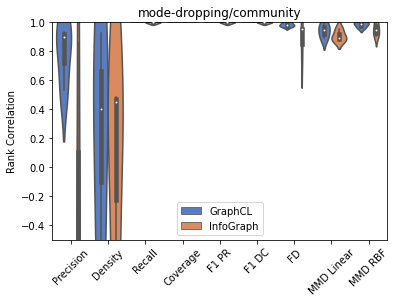

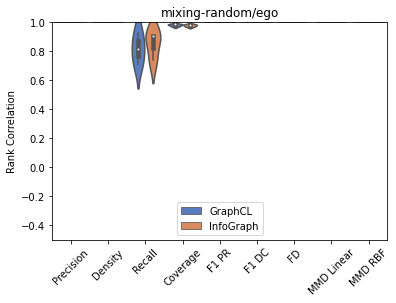

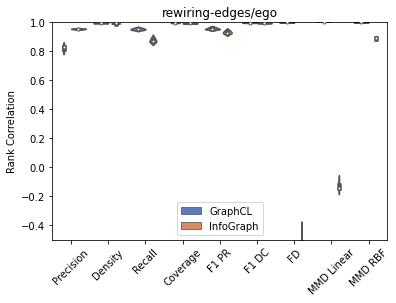

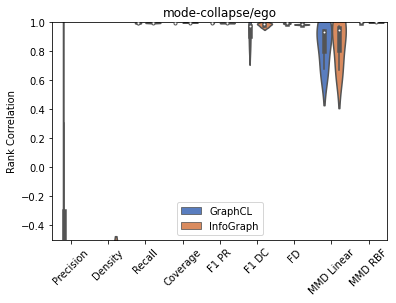

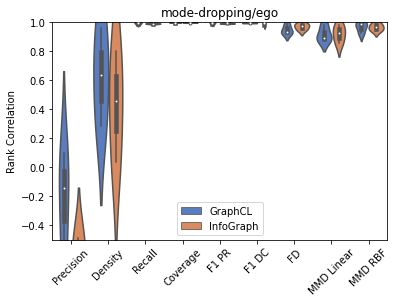

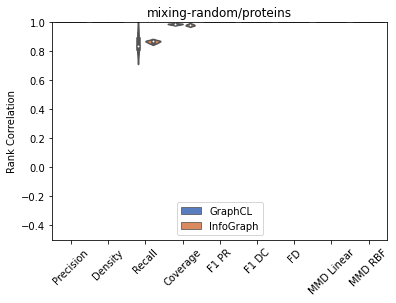

incomplete experiment found:  experiment_results/testing_clustering_feats/infograph/rewiring-edges/proteins/20220526-115524-iK2ZWeqhFW
can not read file:  experiment_results/testing_clustering_feats/infograph/rewiring-edges/proteins/20220526-122113-pLIix6MEOL
can not read file:  experiment_results/testing_clustering_feats/infograph/rewiring-edges/proteins/20220526-120213-iK2ZWeqhFW


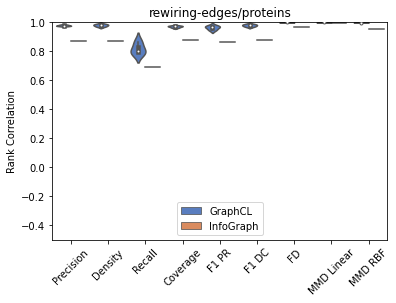

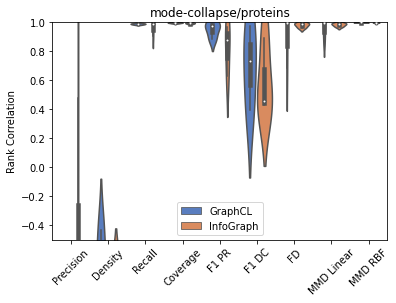

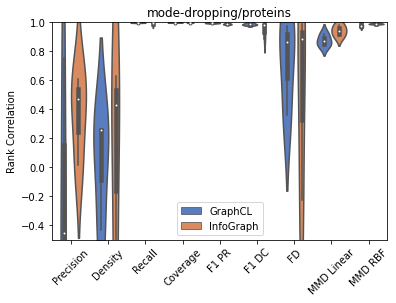

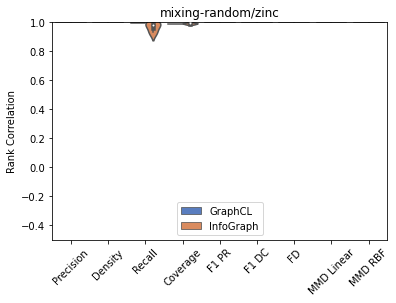

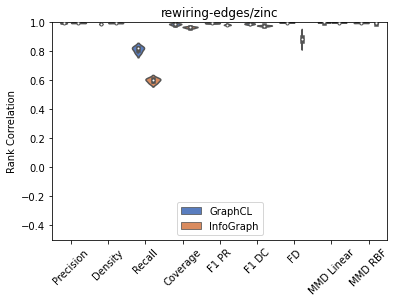

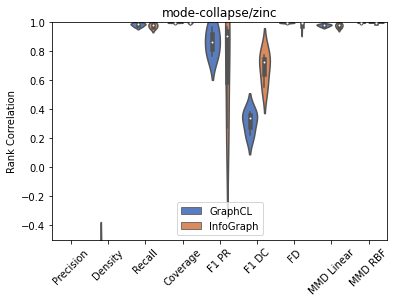

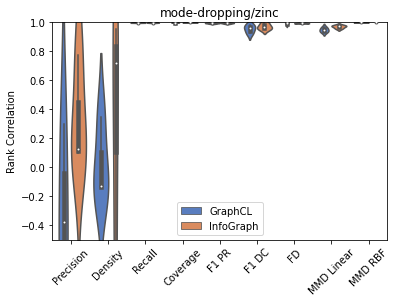

In [32]:
path = 'experiment_results/testing_clustering_feats'
saving_name = 'clustering_feats'
model_names = ['graphcl', 'infograph']
for experiment in all_experiment_names:
    plot_violin_results_compare(path, model_names, experiment, saving_name)
    
for data_name in all_data_names:
    for experiment in all_experiment_names:
        plot_violin_results_compare(path, model_names, experiment, saving_name, data_name)